# Searching for Improvements on Clustering

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import string
import os

#NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [ ]:
import pickle

df_covid = pickle.load(open("plot_data/df_covid.p", "rb"))

## NLP - Create the Processed Text Column

In [5]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

stopwords[:10]

['’s',
 'those',
 'whither',
 '‘re',
 'the',
 "'m",
 'same',
 'amount',
 'wherever',
 'quite']

In [6]:
# Parser
parser = English()
parser.max_length = 4500000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [7]:
tqdm.pandas()
df_covid["processed_text"] = df_covid["body_text"].progress_apply(spacy_tokenizer)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 26043/26043 [25:22<00:00, 17.10it/s]  


## Label Language

In [4]:
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['processed_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df_covid.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 26043/26043 [04:28<00:00, 97.05it/s] 


In [9]:
for lang in set(languages):
    print(lang, ":" ,languages.count(lang))

print("\nTotal:", len(languages))

sv : 2
es : 280
da : 2
pl : 2
de : 31
en : 24934
it : 142
sl : 2
pt : 14
af : 1
cy : 1
ca : 53
zh-cn : 1
ro : 39
lt : 2
fr : 533
nl : 4

Total: 26043


In [10]:
df_covid['language'] = languages

In [11]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26043 entries, 0 to 27677
Data columns (total 13 columns):
paper_id               26043 non-null object
abstract               26043 non-null object
body_text              26043 non-null object
authors                26043 non-null object
title                  26043 non-null object
journal                26043 non-null object
abstract_summary       26043 non-null object
abstract_word_count    26043 non-null int64
body_word_count        26043 non-null int64
body_text_clean        26043 non-null object
abstract_clean         26043 non-null object
processed_text         26043 non-null object
language               26043 non-null object
dtypes: int64(2), object(11)
memory usage: 2.8+ MB


## Let's Save

Now that we have created the language labels, and created the column for the NLP processed text, let's save the dataframe so that we can use it on other notebooks.

In [12]:
# save the COVID-19 DataFrame, too large for github
pickle.dump(df_covid, open("plot_data/df_covid_new.p", "wb" ))

## Sample

In [4]:
df_covid = df_covid.head(9000)

##  CountVectorizer - 2**12

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}', max_features=2**12)
X = cvec.fit_transform(df_covid['processed_text'].values)

In [6]:
X.shape

(1000, 4096)

In [11]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_scale)

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, 
            min_grad_norm=1e-07, 
            metric='euclidean', 
            init='random',
            random_state=None, 
            method='barnes_hut', 
            angle=0.5)
X_embedded = tsne.fit_transform(X_scale)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.088s...
[t-SNE] Computed neighbors for 1000 samples in 6.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 8.063291
[t-SNE] KL divergence after 250 iterations with early exaggeration: 141.033798
[t-SNE] KL divergence after 1000 iterations: 2.224787


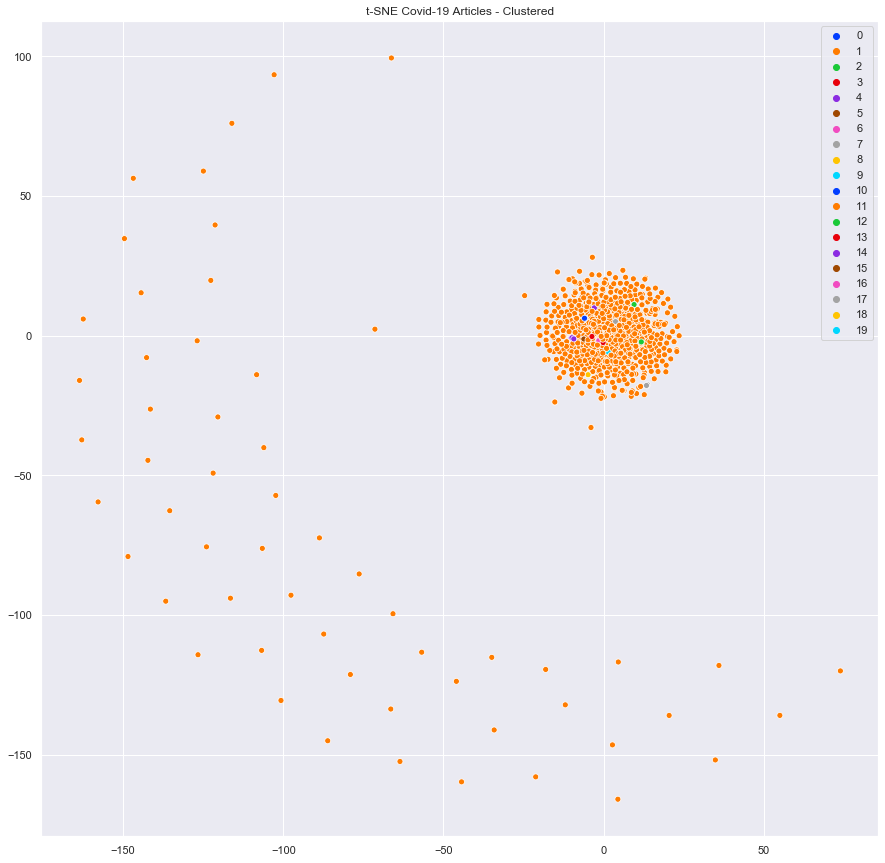

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

## TfidfVectorizer - 2**12

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(df_covid['processed_text'].values)

In [33]:
X.shape

(6000, 4096)

In [34]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, 
            min_grad_norm=1e-07, 
            metric='euclidean', 
            init='random',
            random_state=None, 
            method='barnes_hut', 
            angle=0.5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 1.840s...
[t-SNE] Computed neighbors for 6000 samples in 228.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.323186
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.545258
[t-SNE] KL divergence after 1000 iterations: 1.714538


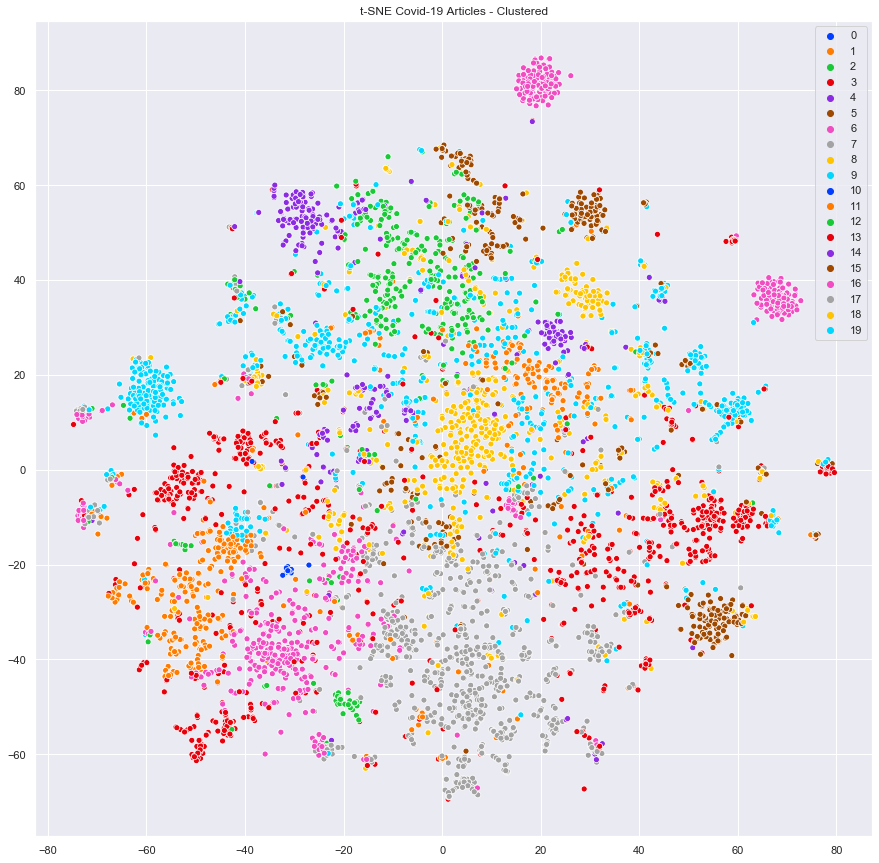

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

## TfidfVectorizer - 2**14

In [5]:
df_covid = df_covid.head(1000)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**14)
X = vectorizer.fit_transform(df_covid['processed_text'].values)

In [8]:
X.shape

(1000, 16384)

In [9]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k, random_state =42)
y_pred = kmeans.fit_predict(X)

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state =42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.376s...
[t-SNE] Computed neighbors for 1000 samples in 27.540s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.324861
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.898064
[t-SNE] KL divergence after 1000 iterations: 1.007969


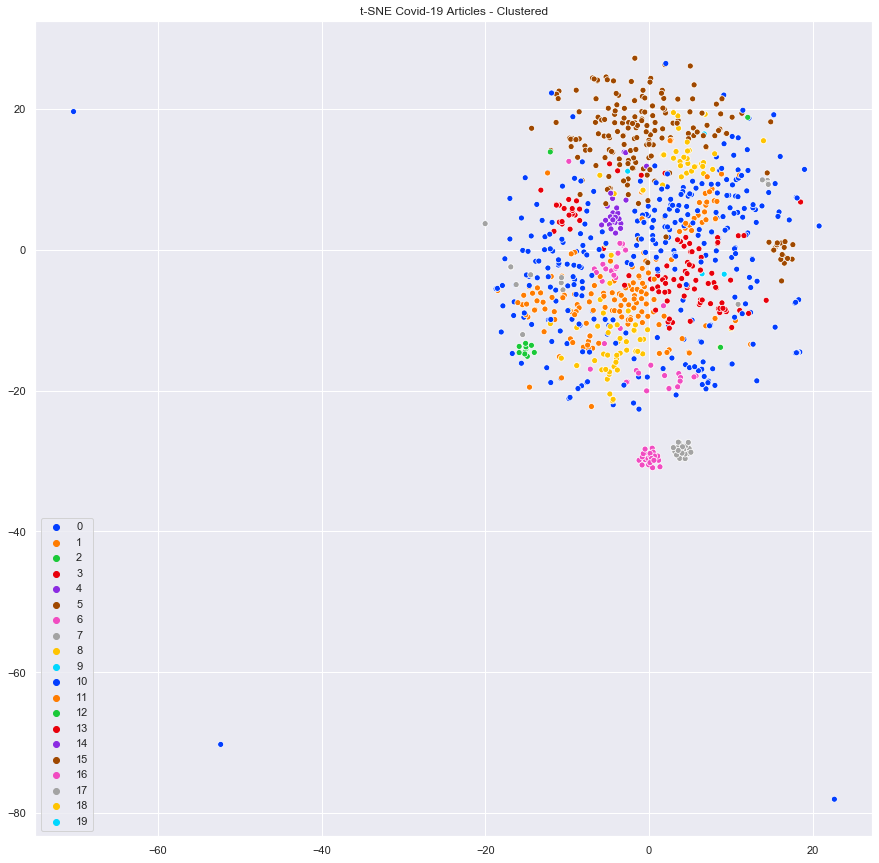

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

## BWMD - PCA

In [42]:
from pyBWMD import vectorize

X = vectorize(list(df_covid['processed_text'].values))

In [43]:
X.shape

(6000, 65536)

In [44]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_embedded = pca.fit_transform(X.toarray())

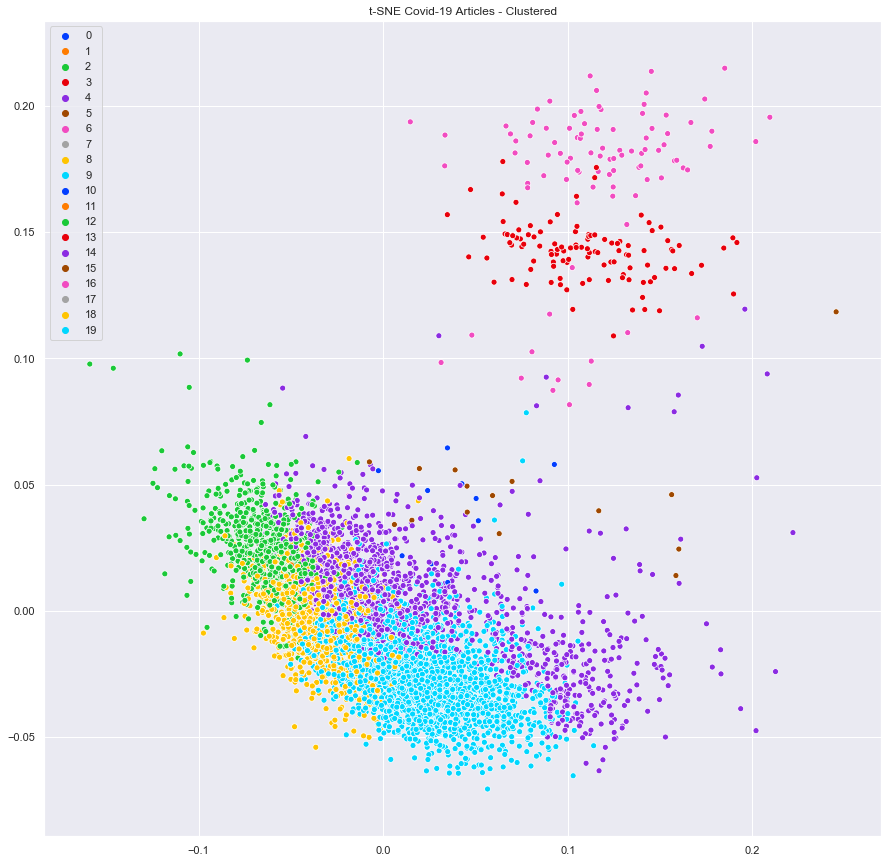

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

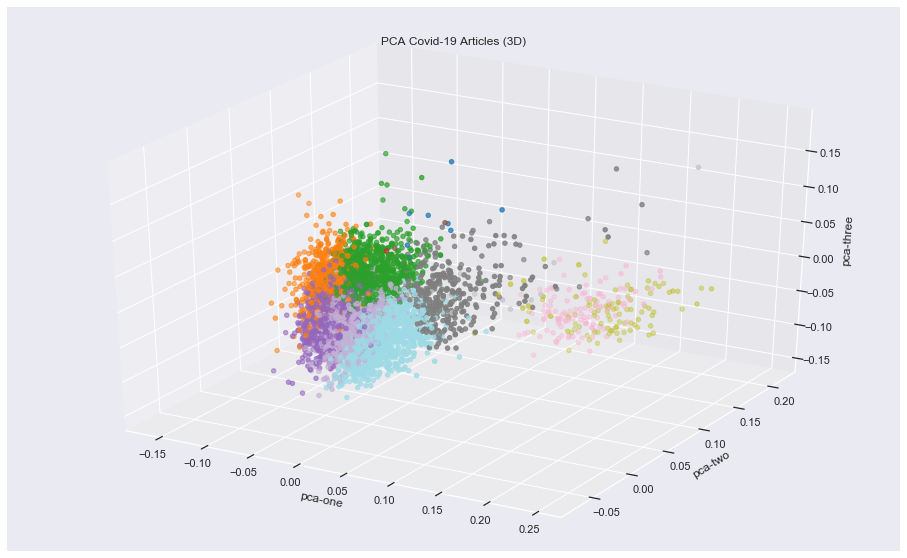

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_embedded[:,0], 
    ys=X_embedded[:,1], 
    zs=X_embedded[:,2], 
    c=y_pred, 
    cmap='tab20'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D)")
plt.show()

## BWMD - t-SNE

In [48]:
from pyBWMD import vectorize

X = vectorize(list(df_covid['processed_text'].values))

In [49]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, 
            min_grad_norm=1e-07, 
            metric='euclidean', 
            init='random',
            random_state=None, 
            method='barnes_hut', 
            angle=0.5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 40.165s...
[t-SNE] Computed neighbors for 6000 samples in 3731.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.033211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.077286
[t-SNE] KL divergence after 1000 iterations: 3.268811


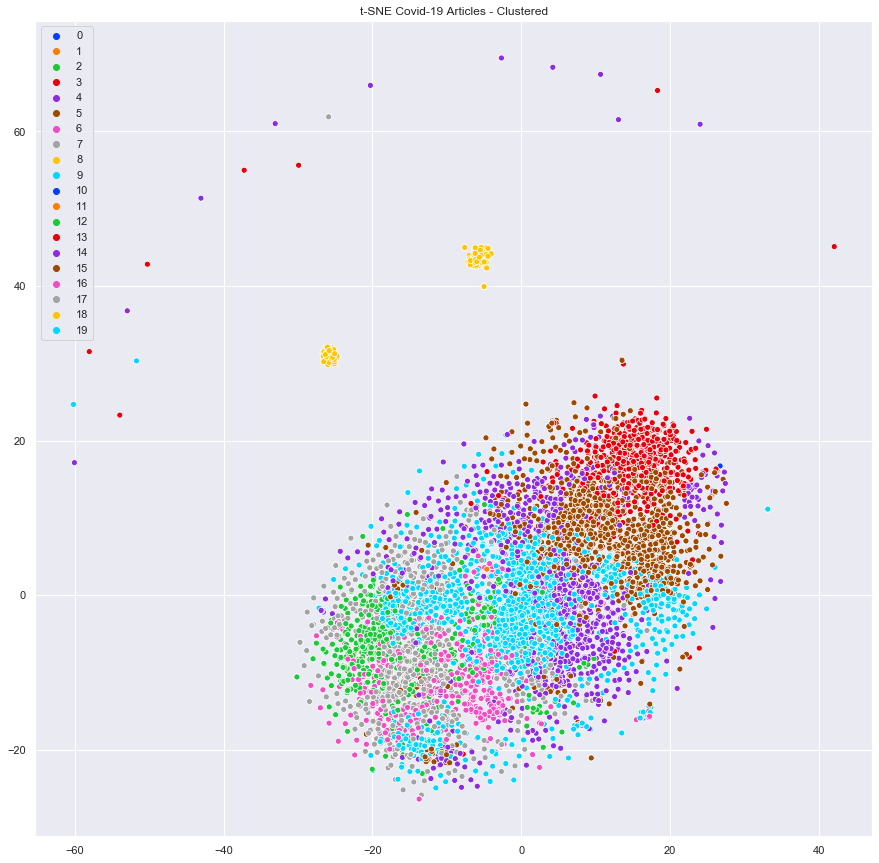

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

##  CountVectorizer - 2**14

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}', max_features=2**14)
X = cvec.fit_transform(df_covid['processed_text'].values)

In [53]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, 
            min_grad_norm=1e-07, 
            metric='euclidean', 
            init='random',
            random_state=None, 
            method='barnes_hut', 
            angle=0.5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 12.612s...
[t-SNE] Computed neighbors for 6000 samples in 920.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 19.559559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.596901
[t-SNE] KL divergence after 1000 iterations: 2.391918


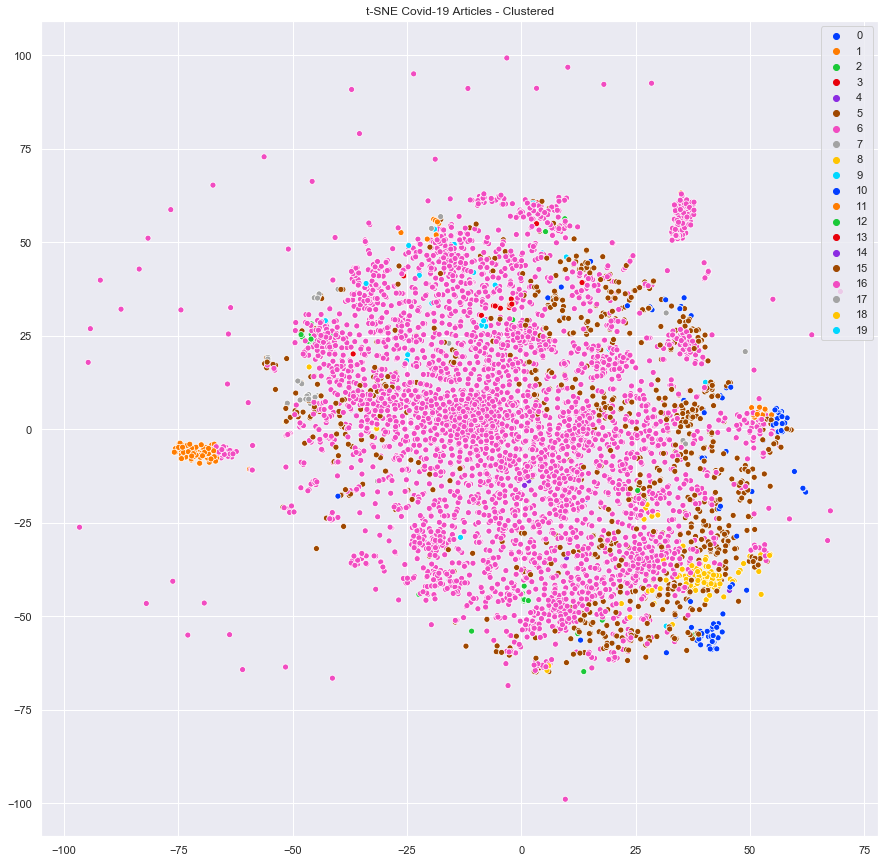

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

## TfidfVectorizer - 2**16

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**16)
X = vectorizer.fit_transform(df_covid['processed_text'].values)

In [57]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, 
            min_grad_norm=1e-07, 
            metric='euclidean', 
            init='random',
            random_state=None, 
            method='barnes_hut', 
            angle=0.5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 30.231s...
[t-SNE] Computed neighbors for 6000 samples in 3645.501s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.313500
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.716156
[t-SNE] KL divergence after 1000 iterations: 1.858178


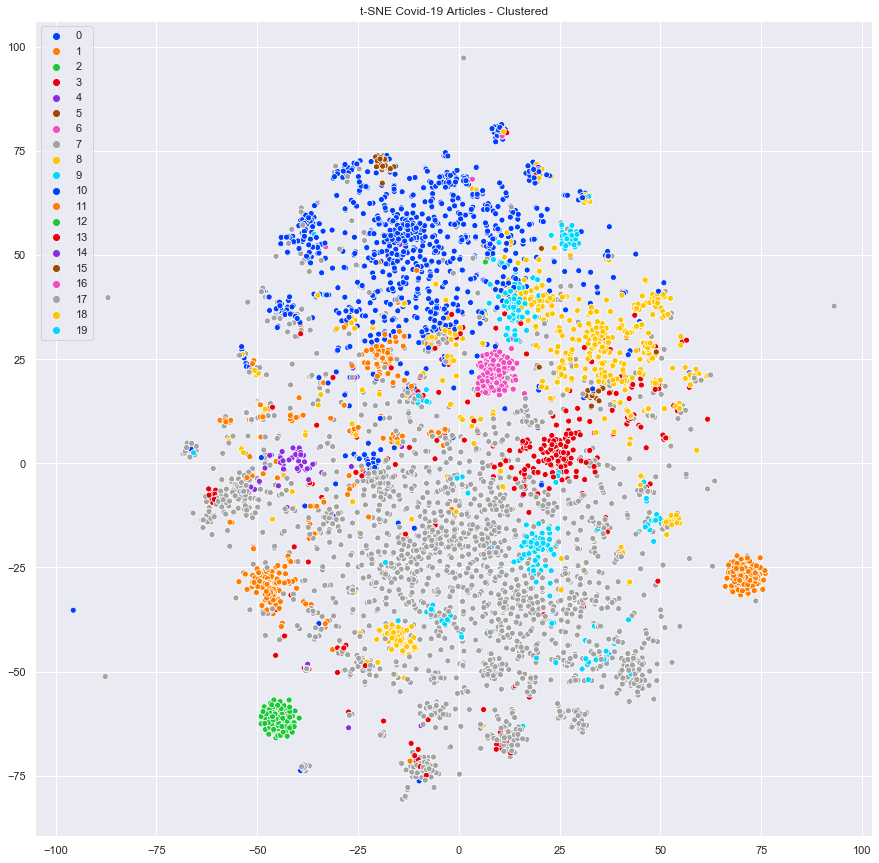

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

### perplexity=5

In [60]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 6000 samples in 52.081s...
[t-SNE] Computed neighbors for 6000 samples in 4408.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.230272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.459152
[t-SNE] KL divergence after 1000 iterations: 1.750172


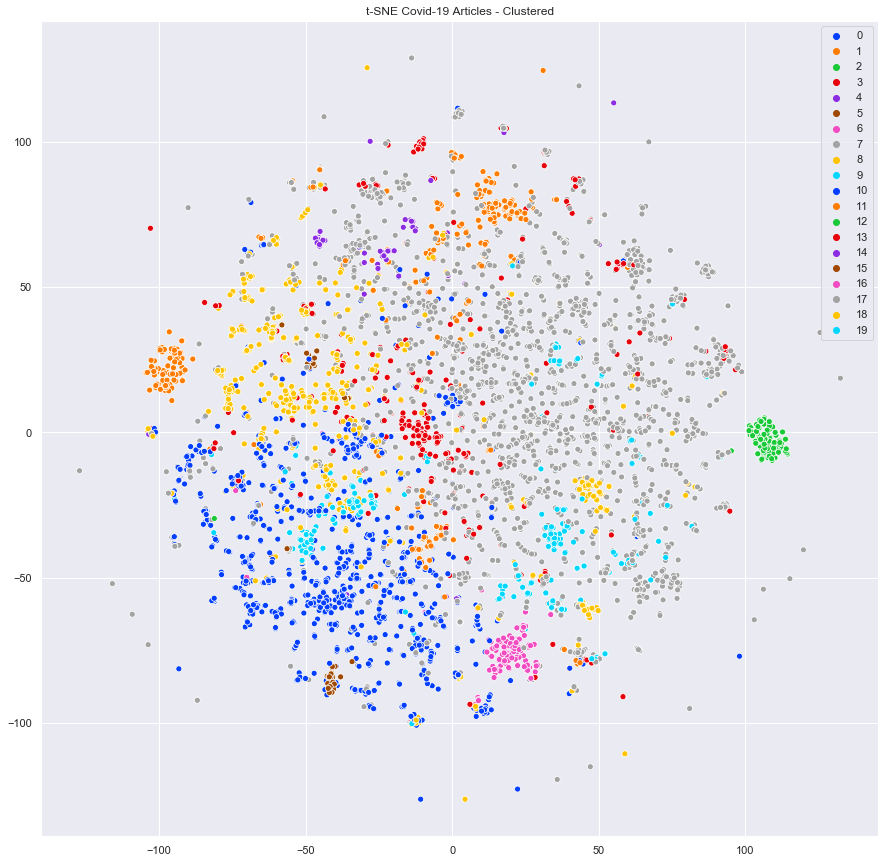

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()

## all default

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 32.457s...
[t-SNE] Computed neighbors for 6000 samples in 4475.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.313500
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.712288
[t-SNE] KL divergence after 1000 iterations: 1.860582


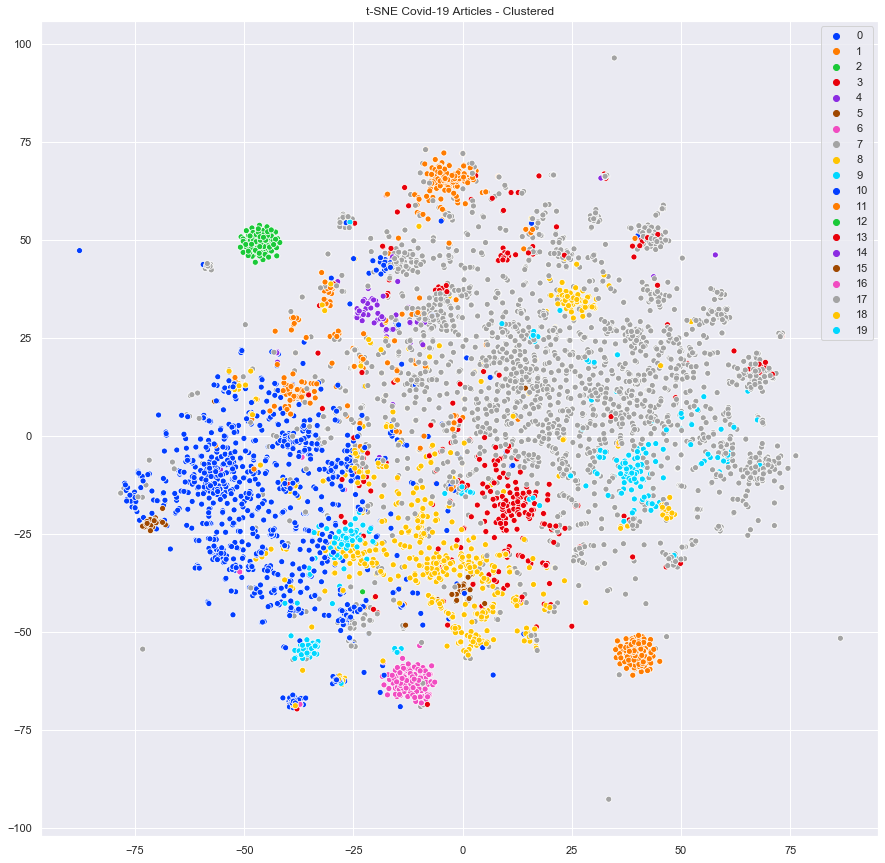

In [63]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.show()